In [7]:
import pandas as pd
import numpy as np
import requests
import asyncio
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import json
import yaml
# import prettytable


Function to get 200 days of energy demand data

In [81]:
"""
This function collects all hourly energy demand data for NY city between the start and end dates provided. 
    It requires an API key for the HTTP Get requests. The EIA has a 5000 value limit, so this function calls a 
    helper function if there are more than 5000 periods between the start and end dates provided.
"""
def get_energy_demand_data(start:np.datetime64, end:np.datetime64, eia_api_key:str=None, medrl:int=5000, **kwargs):
    """
    medrl (maximum energy demand request length) (int): 
    """
    energy_demand = []
    num_days_requested = (end - start).astype("timedelta64[D]").astype(int)
    num_days_per_request = medrl//24
    num_requests = np.ceil(num_days_requested / num_days_per_request)
    print("Number of Requests being made for Energy Demand data: {}".format(num_requests))

    # get api_key for eia
    if eia_api_key is None:
        with open("Permissions/api_keys.yml", "r") as file:
            eia_api_key = yaml.safe_load(file)["eia"]
    
    eia_start = deepcopy(start)
    while eia_start < end:
        eia_end = eia_start + np.timedelta64(num_days_per_request, 'D')
        
        if eia_end > end:
            df = repeated_energy_demand_request(eia_start, end, eia_api_key)
            energy_demand.append(df)
            break
        else:
            df = repeated_energy_demand_request(eia_start, eia_end, eia_api_key)
            energy_demand.append(df)
        eia_start = eia_end

        # wait for 5 seconds before continuing requests (to avoid being cutoff by API)
        # print("sleeping for 30 seconds")
        time.sleep(5)

    energy_demand_data = pd.concat(energy_demand, axis=0)
    energy_demand_data = energy_demand_data[~energy_demand_data.index.duplicated(keep="first")]
    return energy_demand_data

"""
This function requests hourly energy demand data for NY city from the EIA web api. This is a helper function designed to be called 
    repeatedly since only 5000 values can be obtained from the EIA per request.
"""
def repeated_energy_demand_request(start:np.datetime64, end:np.datetime64, eia_api_key:str) -> pd.DataFrame:
    # convert start and end datetimes into hourly strings
    start = np.datetime_as_string(start, unit="h")
    end = np.datetime_as_string(end, unit="h")
    
    # define GET request
    print("Requesting energy demand data from EIA")
    request_url = fr"https://api.eia.gov/v2/electricity/rto/region-sub-ba-data/data/?api_key={eia_api_key}" \
        fr"&frequency=hourly&data[0]=value&facets[parent][]=NYIS&facets[subba][]=ZONJ&" \
        fr"start={start}&end={end}&sort[0][column]=period&sort[0][direction]=asc&offset=0" \

    r = requests.get(request_url)
    energy_demand = r.json()["response"]["data"]
    energy_demand = pd.json_normalize(energy_demand)[["period", "value"]].rename(
        columns={"period":"Time", "value":"Energy Demand (MWH)"}).set_index(["Time"])
    return energy_demand


"""
This function requests monthly energy price data from the EIA web api for the state of New York
"""
def get_energy_price_data(start:np.datetime64, end:np.datetime64, eia_api_key:str=None) -> pd.DataFrame:
    # convert start and end datetimes into monthly strings
    start = np.datetime_as_string(start, unit="M")
    end = np.datetime_as_string(end, unit="M")

    # get api_key for eia
    if eia_api_key is None:
        with open("Permissions/api_keys.yml", "r") as file:
            eia_api_key = yaml.safe_load(file)["eia"]

    # define GET request
    print("Requesting energy price data from EIA")
    request_url = fr"https://api.eia.gov/v2/electricity/retail-sales/data/?api_key={eia_api_key}" \
        fr"&frequency=monthly&data[0]=price&facets[stateid][]=NY&facets[sectorid][]=RES&start={start}" \
        fr"&end={end}&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
    r = requests.get(request_url)
    energy_price = r.json()["response"]["data"]
    energy_price = pd.json_normalize(energy_price)[["period", "price"]].rename(columns={"period":"Time", 
        "price":"Energy Price (cents/KWH)"}).set_index(["Time"])
    return energy_price


"""
This function loads hourly historical weather data for NY city (based on the weather station at central park).
    Still TODO: set up connection to OOSA dataset manager to download a new csv file whenever this function is called.
"""
def get_weather_data(start:np.datetime64, end:np.datetime64):
    # define columns to keep from loaded csv files
    data_columns = [
        "DATE",
        "REPORT_TYPE",
        "SOURCE",
        "HourlyDewPointTemperature",
        "HourlyDryBulbTemperature",
        "HourlyPrecipitation",
        "HourlyRelativeHumidity",
        "HourlyStationPressure",
        "HourlyWetBulbTemperature",
        "HourlyWindSpeed"
    ]

    # download data from NOAA
    print("Requesting Weather Data from NOAA")
    start_year = np.datetime64(start, 'Y').astype(int) + 1970
    end_year = np.datetime64(end, 'Y').astype(int) + 1970
    dfs = []
    for year in range(start_year, end_year+1): # downloads one year's historical weather data one at a time
        df = pd.read_csv("https://www.ncei.noaa.gov/data/local-climatological-data/access/{}/72505394728.csv".format(year), 
            low_memory=False)[data_columns]
        dfs.append(df)
        time.sleep(1)
    weather_data = pd.concat(dfs, axis=0) # combine data from all years

    # filter downloaded data for correct values
    weather_data = weather_data[(weather_data["REPORT_TYPE"]=="FM-15") & (weather_data["SOURCE"]==7)].drop(
        columns={"REPORT_TYPE", "SOURCE"})
    
    # remove 's' characters from data values. I think they indicate "scaled" data points but need to confirm this.
    weather_data = weather_data.replace({"s":""}, regex=True)
    # '*' and 'T' values seem to represent missing data points
    weather_data = weather_data.replace({"T":np.nan, "*":np.nan})

    # filter for the start and end arguments provided
    weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])
    keep_mask = (weather_data["DATE"] > start) & (weather_data["DATE"] < end)
    weather_data = weather_data[keep_mask]

    # format index for joining with other data
    weather_data["DATE"] = weather_data["DATE"].dt.strftime("%Y-%m-%dT%H")
    weather_data = weather_data.rename(columns={"DATE":"Time"}).set_index("Time")

    return weather_data


"""
This function requests several monthly economic indicators from the beruea of labor statistics (BLS) web api. 
    Names for each of the indicators are defined in the function.
"""
def get_bls_data(start_year:int, end_year:int):
    variable_names = {"CUURS12ASA0":"CPI-U", "LAUCT365100000000003":"Unemployment Rate", "LAUCT365100000000004":"Unemployment Level", 
        "LAUCT365100000000005":"Employment Level", "LAUCT365100000000006":"Labor Force Level","LAUCT365100000000007":"Employment Population Ratio",  
        "LAUCT365100000000008":"Labor Force Participation", "LAUCT365100000000009":"Civilian Noninstitutional Population", 
        "SMU36935610000000001":"Payroll Employment"}

    # define GET Request (really using POST)
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": ['CUURS12ASA0', 'LAUCT365100000000003', 'LAUCT365100000000004', 'LAUCT365100000000005', 
        'LAUCT365100000000006', 'LAUCT365100000000007', 'LAUCT365100000000008', 'LAUCT365100000000009', 'SMU36935610000000001'],
        "startyear":str(start_year), "endyear":str(end_year)})
    
    print("Requesting data from Bereau of Labor Statistics")
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    # organize response data
    bls_series = []
    for timeseries in json_data["Results"]["series"]:
        series_name = variable_names[timeseries["seriesID"]]
        series_data = pd.json_normalize(timeseries["data"])
        series_data["Time"] = series_data["year"] + "-" + series_data["period"].str.replace("M","", regex=True)
        series_data = series_data[["Time", "value"]].rename(columns={"value":series_name}).set_index("Time")
        bls_series.append(series_data)
    bls_data = pd.concat(bls_series, axis=1)
    return bls_data
    

"""
This function combines datasets obtained from each of the other functions. It is designed to be flexible, 
    so that either the individual datasets can be passed or, if not passed, then the function to obtain them will be called instead.
"""
def combine_data(energy_demand_data:pd.DataFrame=None, energy_price_data:pd.DataFrame=None, weather_data:pd.DataFrame=None, 
    bls_data:pd.DataFrame=None, start:np.datetime64=None, end:np.datetime64=None, eia_api_key:str=None, oosa_api_key:str=None):
    # if any of the datasets are not provided, need to provide start, end, and api_key
    if energy_demand_data is None: 
        if ([start is None, end is None, eia_api_key is None]).any():
            raise ValueError("If not providing an energy demand dataset, you must provide \"start\", \"end\", and \"eia_api_key\" arguments.")
        energy_demand_data = get_energy_demand_data(start=start, end=end, api_key=eia_api_key)
    else: energy_demand_data = energy_demand_data.copy() # copy dataframe to avoid overwriting
    if energy_price_data is None: 
        if ([start is None, end is None, eia_api_key is None]).any():
            raise ValueError("If not providing an energy price dataset, you must provide \"start\", \"end\", and \"eia_api_key\" arguments.")
        energy_price_data = get_energy_price_data(start=start, end=end, api_key=eia_api_key)
    else: energy_price_data = energy_price_data.copy() # copy dataframe to avoid overwriting
    if weather_data is None: pass
    else: weather_data = weather_data.copy()
    if bls_data is None: 
        if ([start is None, end is None]).any(): raise ValueError("If not providing a weather dataset, you must provide \"start\", and \"end\" arguments.")
        weather_data = 5 # TODO using API
    else: bls_data = bls_data.copy()

    energy_demand_data["Energy Demand Time"] = pd.to_datetime(energy_demand_data.index)
    all_data = pd.concat([energy_demand_data, weather_data], axis=1)
    all_data["Month"] = all_data["Energy Demand Time"].dt.strftime("%Y-%m")
    all_data = pd.merge(all_data, energy_price_data, left_on=["Month"], right_index=True, how="outer")
    all_data = pd.merge(all_data, bls_data, left_on=["Month"], right_index=True, how="outer")

    # get first non-NA value of energy demand
    first_date = pd.to_datetime(all_data["Energy Demand Time"]).min()
    all_data = all_data[all_data["Energy Demand Time"] >= first_date]
    all_data = all_data.drop(columns={"Energy Demand Time", "Month"})
    all_data.index = pd.to_datetime(all_data.index)

    # convert all columns to float
    all_data = all_data.apply(lambda x: x.astype("float", errors="ignore"))

    return all_data

In [77]:
df = get_weather_data(start=np.datetime64("2018-01-01"), end=np.datetime64(datetime.datetime.today()))

Requesting Weather Data from NOAA


In [82]:
energy_demand_data = get_energy_demand_data(start=np.datetime64("2018-01-01"), end=np.datetime64(datetime.datetime.today()))
energy_price_data = get_energy_price_data(start=np.datetime64("2018-01-01"), end=np.datetime64(datetime.datetime.today()))
weather_data = get_weather_data(start=np.datetime64("2018-01-01"), end=np.datetime64(datetime.datetime.today()))
bls_data = get_bls_data(start_year=2018, end_year=2024)

Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics


In [83]:
all_data = combine_data(energy_demand_data=energy_demand_data, energy_price_data=energy_price_data, weather_data=weather_data, bls_data=bls_data)
display(all_data.dtypes)

Energy Demand (MWH)                     float64
HourlyDewPointTemperature               float64
HourlyDryBulbTemperature                float64
HourlyPrecipitation                     float64
HourlyRelativeHumidity                  float64
HourlyStationPressure                   float64
HourlyWetBulbTemperature                float64
HourlyWindSpeed                         float64
Energy Price (cents/KWH)                float64
CPI-U                                   float64
Unemployment Rate                       float64
Unemployment Level                      float64
Employment Level                        float64
Labor Force Level                       float64
Employment Population Ratio             float64
Labor Force Participation               float64
Civilian Noninstitutional Population    float64
Payroll Employment                      float64
dtype: object

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Energy Demand (MWH)'>

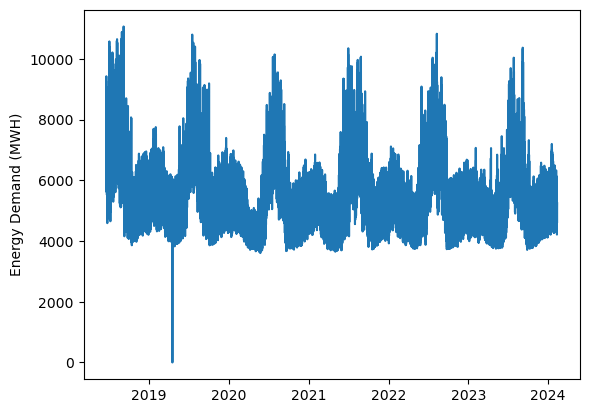

In [84]:
sns.lineplot(data=all_data["Energy Demand (MWH)"].reset_index(), x=all_data.index, y="Energy Demand (MWH)")

In [86]:
# save dataset
all_data.to_csv(r"Datasets/prelim_dataset.csv")

# Look at data

In [40]:
data = pd.read_csv(r"prelim_dataset.csv", index_col=0)

In [42]:
desciptions = data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    # print(n*cols_per_table, (n*cols_per_table)+cols_per_table)
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])
# display(desciptions)
display(data.info())

,Energy Demand (MWH),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure
count,49200.00,47730.00,47739.00,45018.00,47730.00,47529.00
mean,5710.58,42.97,57.07,0.01,62.28,29.88
std,1228.05,19.14,16.86,0.05,19.57,0.23
min,0.00,-17.00,2.00,0.00,7.00,28.71
25%,4815.00,28.00,43.00,0.00,47.00,29.73
50%,5545.00,44.00,57.00,0.00,61.00,29.88
75%,6288.00,59.00,72.00,0.00,78.00,30.04
max,11069.00,79.00,95.00,3.47,100.00,30.59


,HourlyWetBulbTemperature,HourlyWindSpeed,Energy Price (cents/KWH),CPI-U,Unemployment Rate,Unemployment Level
count,47503.00,40549.00,47059.00,48523.00,48523.00,48523.00
mean,50.40,5.00,19.80,294.93,7.14,293521.00
std,15.65,19.54,1.95,17.39,3.97,156851.54
min,0.00,0.00,16.85,273.84,3.30,140697.00
25%,37.00,3.00,18.38,279.47,4.30,183574.00
50%,51.00,5.00,19.29,287.48,5.40,222617.00
75%,64.00,7.00,21.20,313.59,9.90,409961.00
max,81.00,2237.00,23.95,325.61,21.50,836383.00


,Employment Level,Labor Force Level,Employment Population Ratio,Labor Force Participation,Civilian Noninstitutional Population,Payroll Employment
count,48523.00,48523.00,48523.00,48523.00,48523.00,48523.00
mean,3853778.76,4147299.76,55.76,59.99,6915693.82,4465.78
std,238814.31,103952.79,3.58,1.72,174856.23,260.26
min,3046955.00,3707014.00,42.90,52.00,6641170.00,3748.60
25%,3712627.00,4085159.00,54.30,59.60,6746032.00,4225.70
50%,3897289.00,4122588.00,57.40,60.10,6918967.00,4563.10
75%,4076332.00,4254770.00,57.90,60.90,7107466.00,4661.90
max,4141201.00,4322118.00,59.10,62.80,7131615.00,4756.70


<class 'pandas.core.frame.DataFrame'>
Index: 49200 entries, 2018-06-19 05:00:00 to 2024-01-29 05:00:00
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Energy Demand (MWH)                   49200 non-null  float64
 1   HourlyDewPointTemperature             47730 non-null  float64
 2   HourlyDryBulbTemperature              47739 non-null  float64
 3   HourlyPrecipitation                   45018 non-null  float64
 4   HourlyRelativeHumidity                47730 non-null  float64
 5   HourlyStationPressure                 47529 non-null  float64
 6   HourlyWetBulbTemperature              47503 non-null  float64
 7   HourlyWindSpeed                       40549 non-null  float64
 8   Energy Price (cents/KWH)              47059 non-null  float64
 9   CPI-U                                 48523 non-null  float64
 10  Unemployment Rate                     48523 non-null  f

None